# Loan Approval Prediction, a classification problem

### How accurate will we be predicting determinations for loan approval requests?

In [ ]:
# Dataset location - https://www.kaggle.com/shaijudatascience/loan-prediction-practice-av-competition

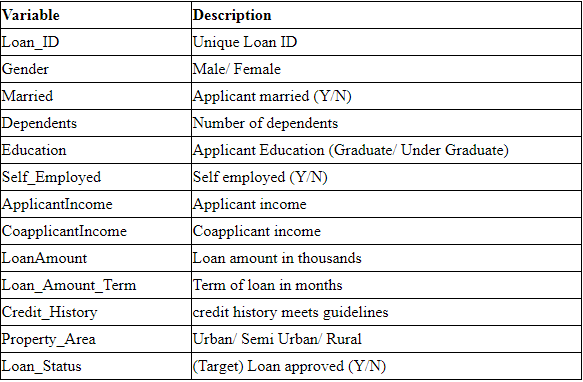

In [5]:
from IPython.display import Image

Image(filename='../images/loan_variables.png')

In [ ]:
# There are 13 variables in the dataset.
# 'Loan_Status' is our target; we are attempting to predict loan approvals.
# To address any potential for data leakage, we will refrain from creating 
# any new features using the target, we won't perform any fitting using our 
# validation sets, and we will watch for any significant declines in our 
# models' performance when scoring our validation sets. 

# Notebook Index

- `Part I, Imports & EDA`
 
- `Part II, Wrangle Data`
  
- `Part III, Split the Data`
    
- `Part IV, Establish a Baseline`

- `Part V, Build Models`
    `-`
   - `LogisticRegression`
   - `RandomForestClassifier` 
   - `XGBoostClassifier`

- `Part VI, Check Metrics`
    `-`
   - `Models, Scores`
   - `Cross Validation Scores`
   - `Confusion Matrices/Precision & Recall`
   - `ROC Curve`

- `Part VII, Tune Models & Recheck Metrics`

# I. Imports & EDA 

In [5]:
# Import packages and package classes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [6]:
# It's a small dataset, but > the threshold of 500 observations.

train = pd.read_csv('../data/class-project/LoanApproval/train_data.csv')

print(train.shape)
train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
# The target vector is 'Loan_Status'

# The classes of the Target Vector are moderately imbalanced towards approval, but < 70%, we 
# can still look at model accuracy for scoring. 
# You have a 68.73% chance of being correct if you always decide that the loan was approved.

train['Loan_Status'].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

In [8]:
# There are a lot of categorical variables; there are NaN values in the dataset. 

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [9]:
# Examine the number of unique entries for variables.

for col in list(train.columns):
    print(col, train[col].nunique())

Loan_ID 614
Gender 2
Married 2
Dependents 4
Education 2
Self_Employed 2
ApplicantIncome 505
CoapplicantIncome 287
LoanAmount 203
Loan_Amount_Term 10
Credit_History 2
Property_Area 3
Loan_Status 2


In [10]:
# Examine 'Dependents' feature

print(train['Dependents'].unique())

['0' '1' '2' '3+' nan]


In [11]:
# Examine 'Property_Area' feature
# No missing values, implies either all loans are home/property purchases, or is
# indicating where loan applicant resides. 

print(train['Property_Area'].value_counts())

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


In [12]:
print(train.describe())

# Possible income outliers present. 'Applicant_Income' and 'Coapplicant_Income' may 
# also need to be scaled. Information from dataset's author indicates 'LoanAmount' 
# is in thousands.  This would mean the min amount requested was $9,000, and the max 
# loan request was $700,000. If the same scale is used for 'ApplicantIncome' it would 
# indicate a low of $150,000, and a high of $81 million - a highly unlikely spread.  
# It would also imply a max 'CoapplicantIncome' of > $41 million!

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  


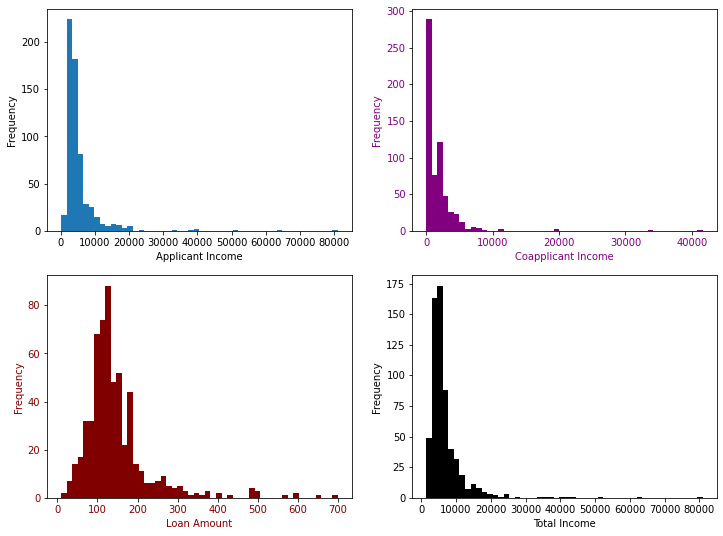

The number of zero entries for "CoapplicantIncome" is 273 / 614


In [13]:
# Complete histogram plots of the continuous variables,
# and explore their distributions.

fig, ax = plt.subplots(2, 2, figsize=(12, 9))

ax[0][0].hist(train['ApplicantIncome'], bins=50)
ax[0][1].hist(train['CoapplicantIncome'], bins=50, color='purple')
ax[1][0].hist(train['LoanAmount'], bins=50, color='maroon')
ax[1][1].hist((train['ApplicantIncome'] + train['CoapplicantIncome']), bins=50, color='black')

ax[0][0].set_xlabel('Applicant Income')
ax[0][0].set_ylabel('Frequency')
ax[0][0].tick_params(axis='x')
ax[0][0].tick_params(axis='y')

ax[0][1].set_xlabel('Coapplicant Income', color='purple')
ax[0][1].set_ylabel('Frequency', color='purple')
ax[0][1].tick_params(axis='x', labelcolor='purple')
ax[0][1].tick_params(axis='y', labelcolor='purple')

ax[1][0].set_xlabel('Loan Amount', color='maroon')
ax[1][0].set_ylabel('Frequency', color='maroon')
ax[1][0].tick_params(axis='x', labelcolor='maroon')
ax[1][0].tick_params(axis='y', labelcolor='maroon')

ax[1][1].set_xlabel('Total Income')
ax[1][1].set_ylabel('Frequency')

plt.show()

print('The number of zero entries for "CoapplicantIncome" is', 
      train['CoapplicantIncome'].value_counts().max(), '/', len(train['CoapplicantIncome']))

# There are a lot of zero entries for 'CoapplicantIncome'! A zero entry for CoapplicantIncome 
# may indicate applicants are from single income households; however, the number accounts 
# almost half of the entries! It's more likely that many loan requests are made by a single 
# filer, and this column is entered as 0 even when there is no coapplicant. This may affect it's 
# predictive power. Can try creating a new feature called 'total_income' that adds applicant 
# income and coapplicant income  together; this new column won't have the ugly 'zero' in it's 
# distribution. 

In [14]:
# Let's scale income and co-applicant income, drop outliers, and rexamine the plots

train['ApplicantIncome'] = train['ApplicantIncome'] / 100
train['CoapplicantIncome'] = train['CoapplicantIncome'] / 100
   
train = train[ (train['ApplicantIncome'] < 250) &
               (train['CoapplicantIncome'] < 250)]
    
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,605.000000,605.000000,583.000000,591.000000,556.000000
mean,49.068777,15.127123,143.317324,342.741117,0.843525
std,34.721025,20.647115,78.533250,64.541662,0.363632
min,1.500000,0.000000,9.000000,12.000000,0.000000
25%,28.760000,0.000000,100.000000,360.000000,1.000000
50%,37.750000,12.130000,127.000000,360.000000,1.000000
75%,57.080000,22.830000,165.000000,360.000000,1.000000
max,238.030000,200.000000,650.000000,480.000000,1.000000


In [15]:
print(train.describe())

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       605.000000         605.000000  583.000000        591.000000   
mean         49.068777          15.127123  143.317324        342.741117   
std          34.721025          20.647115   78.533250         64.541662   
min           1.500000           0.000000    9.000000         12.000000   
25%          28.760000           0.000000  100.000000        360.000000   
50%          37.750000          12.130000  127.000000        360.000000   
75%          57.080000          22.830000  165.000000        360.000000   
max         238.030000         200.000000  650.000000        480.000000   

       Credit_History  
count      556.000000  
mean         0.843525  
std          0.363632  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  


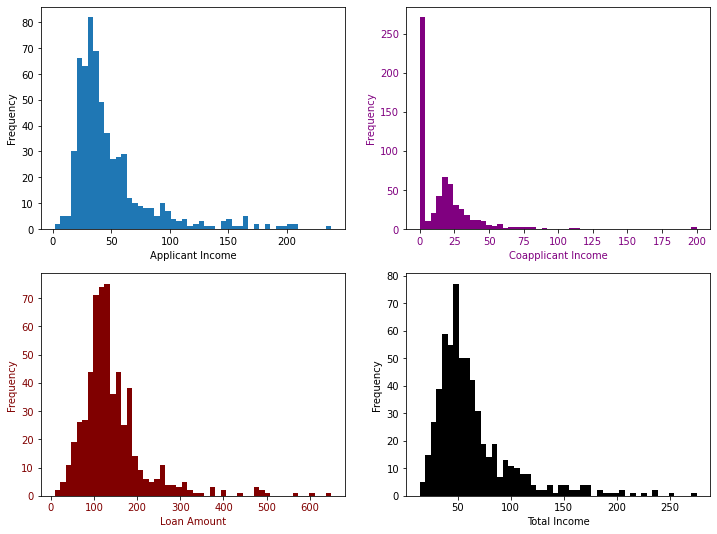

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))

ax[0][0].hist(train['ApplicantIncome'], bins=50)
ax[0][1].hist(train['CoapplicantIncome'], bins=50, color='purple')
ax[1][0].hist(train['LoanAmount'], bins=50, color='maroon')
ax[1][1].hist((train['ApplicantIncome'] + train['CoapplicantIncome']), bins=50, color='black')

ax[0][0].set_xlabel('Applicant Income')
ax[0][0].set_ylabel('Frequency')
ax[0][0].tick_params(axis='x')
ax[0][0].tick_params(axis='y')

ax[0][1].set_xlabel('Coapplicant Income', color='purple')
ax[0][1].set_ylabel('Frequency', color='purple')
ax[0][1].tick_params(axis='x', labelcolor='purple')
ax[0][1].tick_params(axis='y', labelcolor='purple')

ax[1][0].set_xlabel('Loan Amount', color='maroon')
ax[1][0].set_ylabel('Frequency', color='maroon')
ax[1][0].tick_params(axis='x', labelcolor='maroon')
ax[1][0].tick_params(axis='y', labelcolor='maroon')

ax[1][1].set_xlabel('Total Income')
ax[1][1].set_ylabel('Frequency')


plt.show()

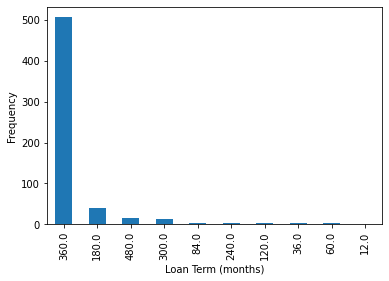

In [17]:
# Examine 'Loan_Amount_Term', listed as a float, really a categorical variable, 10 categories

train['Loan_Amount_Term'].value_counts().plot(kind='bar')

plt.xlabel('Loan Term (months)')
plt.ylabel('Frequency')
plt.show();

# Primarily 30-year notes, likely mortgages. terms of 12-months might indicate a personal loan, 
# 3-year and 5-year durations are more typical with auto-lending.  What's odd, however, is that 
# every observation (all 614) have an input value for 'Property_Area' (urban, semi-urban, rural).
# Further clarification of the data would have been preferred. 

In [18]:
# train.dropna(inplace=True)
# train.info()

In [19]:
# Not every entry with resulting in a denial has a credit history that 
# doesn't meet guidelines.

print(train['Credit_History'].value_counts())
print(train['Loan_Status'].value_counts())

1.0    469
0.0     87
Name: Credit_History, dtype: int64
Y    417
N    188
Name: Loan_Status, dtype: int64


In [20]:
neg_credit_approved_loan = train[ (train['Credit_History'] == 0) &
       (train['Loan_Status'] == 'Y')]

print(neg_credit_approved_loan['Credit_History'])
print(neg_credit_approved_loan['Loan_Status'])

122    0.0
201    0.0
267    0.0
326    0.0
453    0.0
527    0.0
Name: Credit_History, dtype: float64
122    Y
201    Y
267    Y
326    Y
453    Y
527    Y
Name: Loan_Status, dtype: object


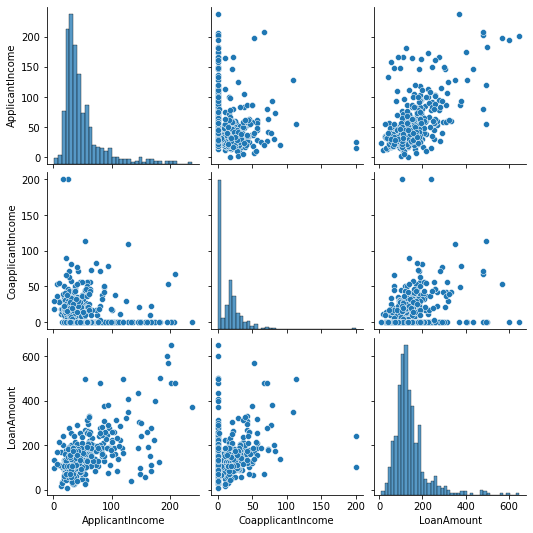

In [21]:
# Examine for correlation among continuous variables; possible outliers noted.

sns.pairplot(train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])
plt.show()

## Summary of Initial EDA

In [ ]:
# 'Loan_ID', high cardinality column, variable is a unique identifier and will be dropped.
# 'Gender', binary categorical variable, assignment == Male/Female, NaN objects hold no meaning.
# 'Married', binary categorical feature, assignment == Y/N, NaN objects hold no meaning.
# 'Dependents', categorical feature, assignment == 0/1/2/3+, NaN objects hold no meaning.
# 'Education', binary categorical feature, assignement == Graduate/Not Graduate, no NaN objects.
# 'Self-Employed', binary categorical feature, assignment = Y/N, NaN objects hold no meaning.
# 'ApplicantIncome', continuous numeric feature, possible outliers, NaN values without meaning.
# 'CoapplicantIncome', continuous numeric feature, possible outliers, NaN values without meaning.
# 'LoanAmount', continuous numeric feature, possible outliers, NaN values without meaning.
# 'Loan_Amount_Term', categorical variable, cardinality == 10, NaN values without meaning.
# 'Credit_History', binary categorical variable, assignment == 1/0, NaN values without meaning. 
# 'Proprty_Area', categorical variable, cardinality == 3, no NaN values. 

# II. Wrangle Data

In [27]:
# Write wrangle function ... this is the accumulation of all prior work and exploration, for 
# best model fit without hyperparameter tuning. 

def wrangle(filepath):

    # Read in the data
    df = pd.read_csv('../data/class-project/LoanApproval/' + filepath)
    
    # Drop high-cardinality identifier column, 'Loan_ID'
    df.drop(columns='Loan_ID', inplace=True)
    
    # Cleanup column names
    df.columns = [col.lower() for col in df.columns]       
    df = df.rename(columns=
        {'applicantincome': 'applicant_income',
         'coapplicantincome': 'coapplicant_income',
         'loanamount': 'loan_amount'})
    
    # Fill NaN values with the mode of the feature it resides in ('most_frequent'); exception, 'loan_amount'
    mode_cols = ['gender', 'married', 'dependents', 'self_employed', 'loan_amount_term', 'credit_history']
    for col in mode_cols:
        df[col].fillna(value=df[col].mode()[0], inplace=True)
    
    # Drop remaining NaN values, all in 'loan_amount' column; difficult to predict without this information. 
    df.dropna(inplace=True)
    
    # Scale 'applicant_income' and 'coapplicant_income' to thousands
    df['applicant_income'] = df['applicant_income'] / 100
    df['coapplicant_income'] = df['coapplicant_income'] / 100
       
    # Convert 'credit_history' to binary categorical from float 
    df['credit_history'].replace(to_replace={1.0: '1', 0.0: '0'}, 
                                 inplace=True)
    
    # Convert 'loan_amount_term' to categorical variable (object) from float
    df['loan_amount_term'] = df['loan_amount_term'].astype(int).astype(str) 

    # Clean 'dependents' feature
    df['dependents'] = df['dependents'].str.strip('+')

    # Convert target, 'LoanStatus' to binary numeric values
    df['loan_status'].replace(to_replace={'Y': 1, 'N':0}, inplace=True) 
  
    # Create 'total_income' feature
    df['total_income'] = df['applicant_income'] + df['coapplicant_income']

    # Create 'loan_to_income' feature
    df['loan_to_income'] = df['loan_amount'] / (df['total_income'])
        
    # Remove the outliers where income is > $250,000
    df = df[ (df['applicant_income'] < 250) &
             (df['coapplicant_income'] < 250)]
   
    # Drop columns noted not to be helpful in predicting loan approval outcome
    df.drop(columns=['dependents', 'applicant_income', 'total_income', 
                   'coapplicant_income', 'property_area'], inplace=True)
    
    return df

train_path = 'train_data.csv'
train= wrangle(train_path)

In [26]:
print(train.shape)
train.head()

(583, 14)


,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status,total_income,loan_to_income
1,Male,Yes,1,Graduate,No,45.83,15.08,128.0,360,1,Rural,0,60.91,2.101461
2,Male,Yes,0,Graduate,Yes,30.00,0.00,66.0,360,1,Urban,1,30.00,2.200000
3,Male,Yes,0,Not Graduate,No,25.83,23.58,120.0,360,1,Urban,1,49.41,2.428658
4,Male,No,0,Graduate,No,60.00,0.00,141.0,360,1,Urban,1,60.00,2.350000
5,Male,Yes,2,Graduate,Yes,54.17,41.96,267.0,360,1,Urban,1,96.13,2.777489


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 1 to 613
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              583 non-null    object 
 1   married             583 non-null    object 
 2   dependents          583 non-null    object 
 3   education           583 non-null    object 
 4   self_employed       583 non-null    object 
 5   applicant_income    583 non-null    float64
 6   coapplicant_income  583 non-null    float64
 7   loan_amount         583 non-null    float64
 8   loan_amount_term    583 non-null    object 
 9   credit_history      583 non-null    object 
 10  property_area       583 non-null    object 
 11  loan_status         583 non-null    int64  
 12  total_income        583 non-null    float64
 13  loan_to_income      583 non-null    float64
dtypes: float64(5), int64(1), object(8)
memory usage: 68.3+ KB


In [22]:
train.describe()

,applicant_income,coapplicant_income,loan_amount,loan_status,total_income,loan_to_income
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,48.889966,15.303343,143.317324,0.696398,64.193309,2.400922
std,34.318403,20.864139,78.533250,0.460208,37.503191,0.808459
min,1.500000,0.000000,9.000000,0.000000,14.420000,0.301614
25%,28.855000,0.000000,100.000000,0.000000,41.565000,1.962545
50%,37.620000,12.500000,127.000000,1.000000,53.320000,2.428658
75%,57.030000,23.040000,165.000000,1.000000,73.580000,2.825673
max,238.030000,200.000000,650.000000,1.000000,275.000000,8.271164


# III. Split the Data

In [28]:
# Create Feature Matrix and Target Array

target = 'loan_status'

y = train[target]
X = train.drop(columns=target)

In [29]:
# Split the data
# Will use a random split; there is no datetime information included in this dataset.

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# IV. Establish a Baseline

In [25]:
# The target vector is 'Loan_Status'
# The classes of the TV are moderately imbalanced towards approval, but < 70%, so we can still look at 
# model accuracy for scoring. 

# You have a 69.64% chance of being correct if you always decide that 
# the loan application was approved.

print('Baseline Accuracy for predicting Loan Approval: {:.2f}%'.format
      (y.value_counts(normalize=True).max()*100))


Baseline Accuracy for predicting Loan Approval: 69.64%


# V. Build Models

- `LogisticRegression`
    
    - `OneHotEncoder`
    - `StandardScaler`
 
- `RandomForrestClassifier`

    - `OrdinalEncoder`
    
- `XGBClassifier`

    - `OrdinalEncoder`

In [30]:
# Model 1: Logistic Regression Model

model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

/Users/frankhowd/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-YelssOLa/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [31]:
# Model 2: Random Forest Classifier Model

model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_jobs=-1, random_state=42)
)

model_rf.fit(X_train, y_train);

In [32]:
# Model 3: XG-Boost Classifier

model_xgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(random_state=42, n_jobs=-1)
)

model_xgb.fit(X_train, y_train);

# VI. Check Metrics

In [29]:
# Training and Testing accuracy of our Logistic Regression model

print('Training Accuracy (LOGR): {:.2f}%'.format(model_lr.score(X_train, y_train)*100))
print('Validation Accuracy (LOGR): {:.2f}%'.format(model_lr.score(X_val, y_val)*100))

Training Accuracy (LOGR): 82.40%
Validation Accuracy (LOGR): 81.20%


In [30]:
# Cross Validation Score for our Logistic Regression model

lr_cvs = cross_val_score(model_lr, X_train, y_train, cv=5, n_jobs=-1)

print('Cross Validation Score (LOGR):')
for _ in range(5):
    print('{:.2f}%'.format(lr_cvs[_]*100))

Cross Validation Score (LOGR):
76.60%
79.57%
84.95%
82.80%
82.80%


In [31]:
# Training and Testing accuracy of our Random Forest Classifier model

print('Training Accuracy(RF): {:.2f}%'.format(model_rf.score(X_train, y_train)*100))
print('Validation Accuracy (RF): {:.2f}%'.format(model_rf.score(X_val, y_val)*100))

Training Accuracy(RF): 100.00%
Validation Accuracy (RF): 80.34%


In [32]:
# Cross Validation Score for our Random Forest Classifier model

rf_cvs = cross_val_score(model_rf, X_train, y_train, cv=5, n_jobs=-1)

print('Cross Validation Score (LOGR):')
for _ in range(5):
    print('{:.2f}%'.format(rf_cvs[_]*100))

Cross Validation Score (LOGR):
76.60%
78.49%
83.87%
84.95%
82.80%


In [33]:
# Training and Testing accuracy of our XGBoost Classifier model

print('Training Accuracy(XGB): {:.2f}%'.format(model_xgb.score(X_train, y_train)*100))
print('Validation Accuracy (XGB): {:.2f}%'.format(model_xgb.score(X_val, y_val)*100))

Training Accuracy(XGB): 100.00%
Validation Accuracy (XGB): 78.63%


In [34]:
# Cross Validation Score for our XGBoost Classifier model

xgb_cvs = cross_val_score(model_xgb, X_train, y_train, cv=5, n_jobs=-1)

print('Cross Validation Score (XGB):')
for _ in range(5):
    print('{:.2f}%'.format(xgb_cvs[_]*100))

Cross Validation Score (XGB):
73.40%
76.34%
82.80%
83.87%
81.72%


In [35]:
# Initial performances appear the same on average, however, the RF Classifier achieves higher scores
# during cross validation testing. 

In [36]:
# LOGISTIC REGRESSION, performance
# Not very good precision for Y, great recall for Y

print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.39      0.56        36
           1       0.79      1.00      0.88        81

    accuracy                           0.81       117
   macro avg       0.89      0.69      0.72       117
weighted avg       0.85      0.81      0.78       117



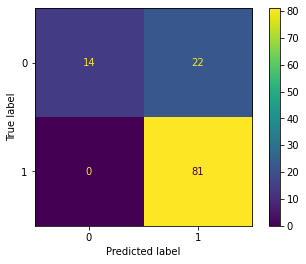

In [37]:
# LOGISTIC REGRESSION
# Plot Confusion Matrix

plot_confusion_matrix(model_lr, X_val, y_val, values_format='.0f');

# TN FP
# FN TP

In [38]:
# LOGISTIC REGRESSION
# Calculate Precision and Recall

# Precision = TP / (TP + FP)
precision = 81 / (81 + 22)

# Recall = TP / (TP + FN)
recall = 81 / (81 + 0)

print('Logistic Regression model precision: {:.2f}%'.format(precision*100))
print('Logistic Regression model recall: {:.2f}%'.format(recall*100))

Logistic Regression model precision: 78.64%
Logistic Regression model recall: 100.00%


In [39]:
# RANDOM FOREST CLASSIFIER, preformance
# Not very good precision for Y, great recall for Y

print('Random Forest Classifier')
print(classification_report(y_val, model_rf.predict(X_val)))

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.81      0.47      0.60        36
           1       0.80      0.95      0.87        81

    accuracy                           0.80       117
   macro avg       0.81      0.71      0.73       117
weighted avg       0.80      0.80      0.79       117



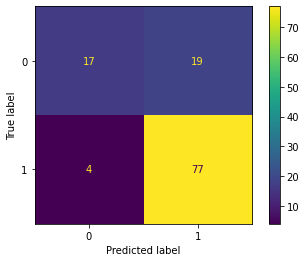

In [40]:
# RANDOM FOREST CLASSIFIER
# Plot Confusion Matrix

plot_confusion_matrix(model_rf, X_val, y_val, values_format='.0f');

# TN FP
# FN TP

In [41]:
# RANDOM FOREST CLASSIFIER 
# Calculate Precision and Recall

# Precision = TP / (TP + FP)
precision = 77 / (77 + 19)

# Recall = TP / (TP + FN)
recall = 77 / (77 + 4)

print('Random Forest Classifier precision: {:.2f}%'.format(precision*100))
print('Random Forest Classifier recall: {:.2f}%'.format(recall*100))

Random Forest Classifier precision: 80.21%
Random Forest Classifier recall: 95.06%


In [42]:
# XGBoost Classifier, preformance

print('XGBoost Classifier')
print(classification_report(y_val, model_xgb.predict(X_val)))

XGBoost Classifier
              precision    recall  f1-score   support

           0       0.76      0.44      0.56        36
           1       0.79      0.94      0.86        81

    accuracy                           0.79       117
   macro avg       0.78      0.69      0.71       117
weighted avg       0.78      0.79      0.77       117



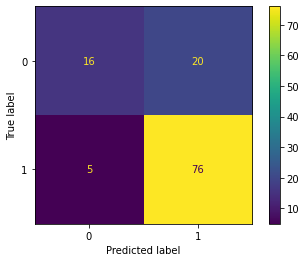

In [43]:
# XGBoost Classifier
# Plot Confusion Matrix

plot_confusion_matrix(model_xgb, X_val, y_val, values_format='.0f');

# TN FP
# FN TP

# XGBoost Classifier

In [44]:
# XGBOOST CLASSIFIER 
# Calculate Precision and Recall

# Precision = TP / (TP + FP)
precision = 76 / (76 + 20)

# Recall = TP / (TP + FN)
recall = 76 / (76 + 5)

print('XGBoost Classifier precision: {:.2f}%'.format(precision*100))
print('XGBoost Classifier recall: {:.2f}%'.format(recall*100))

XGBoost Classifier precision: 79.17%
XGBoost Classifier recall: 93.83%


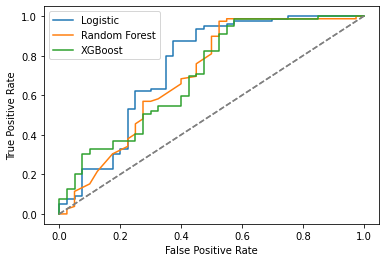

In [1210]:
# INCOME OUTLIERS NOT REMOVED
# Plot ROC curve to evaluate the models 
# 'How far up can I go without having to go too far to the right?'

lr = plot_roc_curve(model_lr, X_val, y_val, label='Logistic')
rf = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_, label='Random Forest')
xgb = plot_roc_curve(model_xgb, X_val, y_val, ax=lr.ax_, label='XGBoost')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

In [1211]:
print('Logistic: ROA-AUC Score: {:.2f}%'.format(roc_auc_score(y_val, model_lr.predict(X_val))*100))
print('Random Forest: ROC-AUC Score:: {:.2f}%'.format(roc_auc_score(y_val, model_rf.predict(X_val))*100))
print('XGBoost: ROC-AUC Score:: {:.2f}%'.format(roc_auc_score(y_val, model_xgb.predict(X_val))*100))

Logistic: ROA-AUC Score: 69.98%
Random Forest: ROC-AUC Score:: 69.95%
XGBoost: ROC-AUC Score:: 66.16%


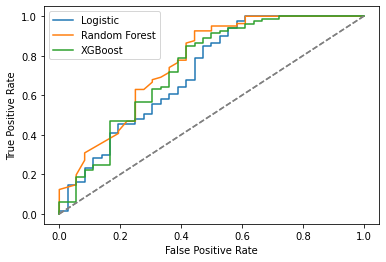

In [50]:
# INCOME OUTLIERS REMOVED

lr = plot_roc_curve(model_lr, X_val, y_val, label='Logistic')
rf = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_, label='Random Forest')
xgb = plot_roc_curve(model_xgb, X_val, y_val, ax=lr.ax_, label='XGBoost')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

In [52]:
print('Logistic: ROA-AUC Score: {:.4f}'.format(roc_auc_score(y_val, model_lr.predict(X_val))))
print('Random Forest: ROC-AUC Score: {:.4f}'.format(roc_auc_score(y_val, model_rf.predict(X_val))))
print('XGBoost: ROC-AUC Score:: {:.4f}'.format(roc_auc_score(y_val, model_xgb.predict(X_val))))

Logistic: ROA-AUC Score: 0.6944
Random Forest: ROC-AUC Score: 0.7114
XGBoost: ROC-AUC Score:: 0.6914


In [ ]:
# Not the greatest looking curves.

# VII. Tune Model & Recheck Metrics

In [53]:
# Let's look at the feature importances of our RF and XGBoost Classifier model.

# Random Forest Classifier
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

self_employed         0.014831
gender                0.017522
education             0.019529
married               0.021471
loan_amount_term      0.022803
dependents            0.031231
property_area         0.051793
coapplicant_income    0.070302
loan_amount           0.115186
applicant_income      0.118273
total_income          0.118723
loan_to_income        0.140659
credit_history        0.257677
dtype: float64

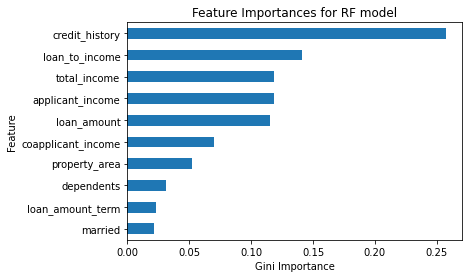

In [54]:
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for RF model')
plt.show()

In [55]:
# Let's permute the data - we'll shuffle the data in a column to create 
# noise-static.  We can see how much it previously helped the model's
# prediction by taking away it's predictive power.

perm_imp = permutation_importance(
    model_rf,
    X_val, # Always use your VALIDATION set
    y_val,
    n_jobs=-1,
    random_state=42
)

In [56]:
perm_imp.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [57]:
# Put results into a DataFrame
data = {'importances_mean': perm_imp['importances_mean'],
        'importances_std': perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values(by='importances_mean', inplace=True)

In [58]:
df

,importances_mean,importances_std
property_area,-0.013675,0.008716
coapplicant_income,-0.011966,0.004187
total_income,-0.011966,0.004187
applicant_income,-0.010256,0.003419
dependents,-0.006838,0.006396
gender,0.000000,0.000000
self_employed,0.000000,0.000000
loan_amount_term,0.001709,0.003419
education,0.001709,0.009967
loan_amount,0.005128,0.011594


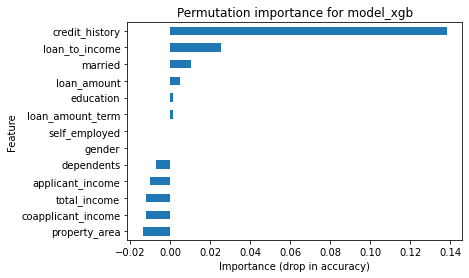

In [59]:
df['importances_mean'].tail(13).plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb')
plt.show()

In [60]:
# XGBoost
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

dependents            0.035617
total_income          0.038766
loan_amount           0.040802
coapplicant_income    0.042742
applicant_income      0.042939
loan_amount_term      0.045274
gender                0.046137
loan_to_income        0.046410
education             0.047946
married               0.049466
self_employed         0.056401
property_area         0.072983
credit_history        0.434518
dtype: float32

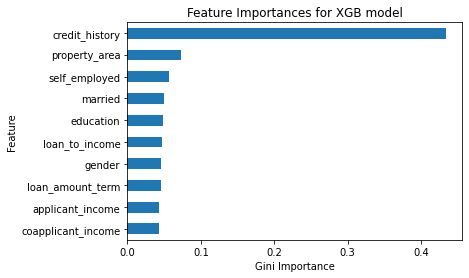

In [61]:
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XGB model')
plt.show()

In [62]:
# Put results into a DataFrame
data = {'importances_mean': perm_imp['importances_mean'],
        'importances_std': perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values(by='importances_mean', inplace=True)

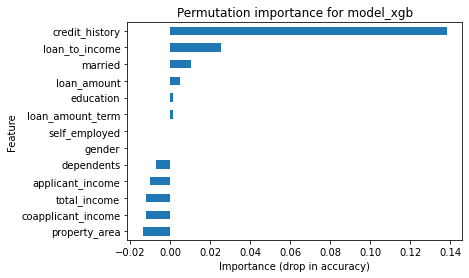

In [63]:
df['importances_mean'].tail(13).plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb')
plt.show()

In [ ]:
# It looks like many columns didn't help or actually detract from the model's predictive power.
# Let's remove these features, run the models again, and check their performance.

# 'dependents', 'applicant_income', 'total_income', 'coapplicant_income', 'property_area'

In [33]:
# Training and Validation accuracy of our Logistic Regression model 

print('Training Accuracy (LOGR): {:.2f}%'.format(model_lr.score(X_train, y_train)*100))
print('Validation Accuracy (LOGR): {:.2f}%'.format(model_lr.score(X_val, y_val)*100))

Training Accuracy (LOGR): 82.19%
Validation Accuracy (LOGR): 81.20%


In [34]:
# Training and Validation accuracy of our Random Forest Classifier model
# Performance improved

print('Training Accuracy(RF): {:.2f}%'.format(model_rf.score(X_train, y_train)*100))
print('Validation Accuracy (RF): {:.2f}%'.format(model_rf.score(X_val, y_val)*100))

Training Accuracy(RF): 100.00%
Validation Accuracy (RF): 79.49%


In [35]:
# Training and Validation accuracy of our XGBoost Classifier model
# Performance improved

print('Training Accuracy(XGB): {:.2f}%'.format(model_xgb.score(X_train, y_train)*100))
print('Validation Accuracy (XGB): {:.2f}%'.format(model_xgb.score(X_val, y_val)*100))

Training Accuracy(XGB): 99.79%
Validation Accuracy (XGB): 76.07%


In [ ]:
# Let's try some hyperparameter tuning of the models. 

In [806]:
# Tune Logistic Regression Model

penalty_variants = ['l2', 'none']
solver_variants = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# No effect witnessed with tuning of this hyperparameter
# for _ in penalty_variants:
#     model_lr_tune = make_pipeline(
#         OneHotEncoder(use_cat_names=True),
#         StandardScaler(),
#         LogisticRegression(penalty=_)
#     )
#     model_lr_tune.fit(X_train, y_train);
#     print(_, 'Validation Accuracy (LOGR_penalty_tuned):', model_lr.score(X_val, y_val), "\n")

# No effect witnessed with tuning of this hyperparameter
# for _ in range(1, 11):
#     model_lr_tune = make_pipeline(
#         OneHotEncoder(use_cat_names=True),
#         StandardScaler(),
#         LogisticRegression(C=_)
#     )
#     model_lr_tune.fit(X_train, y_train);
#     print(_, 'Validation Accuracy (LOGR_penalty_tuned):', model_lr.score(X_val, y_val), "\n")

# No effect witnessed with tuning of this hyperparameter
# for _ in solver_variants:
#     model_lr_tune = make_pipeline(
#         OneHotEncoder(use_cat_names=True),
#         StandardScaler(),
#         LogisticRegression(solver=_)
#     )
#     model_lr_tune.fit(X_train, y_train);
#     print(_, 'Validation Accuracy (LOGR_penalty_tuned):', model_lr.score(X_val, y_val), "\n")

In [1457]:
# Complete a RandomizedSearchCV for our RF model

params = {'randomforestclassifier__n_estimators': np.arange(20, 100, 5), 
          'randomforestclassifier__max_depth': np.arange(10, 75, 5),
          'randomforestclassifier__max_samples': np.arange(0.1, 0.99, 0.1)}

rf_rs = RandomizedSearchCV(model_rf, param_distributions=params, n_iter=10, cv=5, n_jobs=-1, verbose=1)

In [1458]:
rf_rs.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.5s finished
/Users/frankhowd/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-YelssOLa/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [1459]:
# Score is imporoved to nearly 82%

rf_rs.best_score_

0.8198123999084878

In [1460]:
rf_rs.best_params_

{'randomforestclassifier__n_estimators': 70,
 'randomforestclassifier__max_samples': 0.2,
 'randomforestclassifier__max_depth': 15}

In [36]:
# Model 2: Random Forest Classifier Model with best params

model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_estimators=70, max_samples=0.2, max_depth=15,
                           n_jobs=-1, random_state=42)
)

model_rf.fit(X_train, y_train);

In [37]:
# Training and Validation accuracy of our Logistic Regression Classifier model

print('Training Accuracy(RF): {:.2f}%'.format(model_lr.score(X_train, y_train)*100))
print('Validation Accuracy (RF): {:.2f}%'.format(model_lr.score(X_val, y_val)*100))

Training Accuracy(RF): 82.19%
Validation Accuracy (RF): 81.20%


In [38]:
# Training and Validation accuracy of our Random Forest Classifier model

print('Training Accuracy(RF): {:.2f}%'.format(model_rf.score(X_train, y_train)*100))
print('Validation Accuracy (RF): {:.2f}%'.format(model_rf.score(X_val, y_val)*100))

Training Accuracy(RF): 84.55%
Validation Accuracy (RF): 82.91%


In [39]:
print('Random Forest Classifier')
print(classification_report(y_val, model_lr.predict(X_val)))

Random Forest Classifier
              precision    recall  f1-score   support

           0       1.00      0.39      0.56        36
           1       0.79      1.00      0.88        81

    accuracy                           0.81       117
   macro avg       0.89      0.69      0.72       117
weighted avg       0.85      0.81      0.78       117



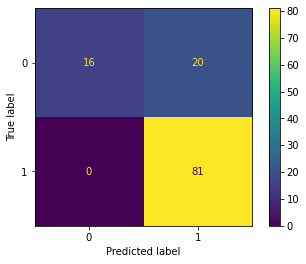

In [40]:
# RANDOM FOREST CLASSIFIER
# Plot Confusion Matrix

plot_confusion_matrix(model_rf, X_val, y_val, values_format='.0f');

# TN FP
# FN TP

In [41]:
print('Random Forest Classifier')
print(classification_report(y_val, model_rf.predict(X_val)))

Random Forest Classifier
              precision    recall  f1-score   support

           0       1.00      0.44      0.62        36
           1       0.80      1.00      0.89        81

    accuracy                           0.83       117
   macro avg       0.90      0.72      0.75       117
weighted avg       0.86      0.83      0.81       117



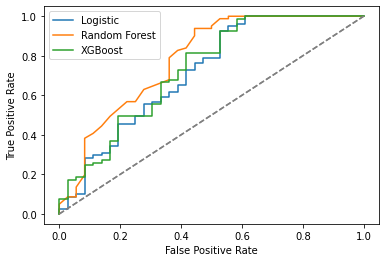

In [42]:
# Final ROC curve

lr = plot_roc_curve(model_lr, X_val, y_val, label='Logistic')
rf = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_, label='Random Forest')
xgb = plot_roc_curve(model_xgb, X_val, y_val, ax=lr.ax_, label='XGBoost')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

In [43]:
print('Logistic: ROA-AUC Score: {:.4f}'.format(roc_auc_score(y_val, model_lr.predict(X_val))))
print('Random Forest: ROC-AUC Score:: {:.4f}'.format(roc_auc_score(y_val, model_rf.predict(X_val))))
print('XGBoost: ROC-AUC Score:: {:.4f}'.format(roc_auc_score(y_val, model_xgb.predict(X_val))))

Logistic: ROA-AUC Score: 0.6944
Random Forest: ROC-AUC Score:: 0.7222
XGBoost: ROC-AUC Score:: 0.6806


# Retesting of Logistic Regression and Random Forest Models without inclusion of 'Credit_History' Feature

In [44]:
def wrangle(filepath):

    # Read in the data
    df = pd.read_csv('../data/class-project/LoanApproval/' + filepath)
    
    # Drop high-cardinality identifier column, 'Loan_ID'
    df.drop(columns=['Loan_ID', 'Credit_History'], inplace=True)
    
    # Cleanup column names
    df.columns = [col.lower() for col in df.columns]       
    df = df.rename(columns=
        {'applicantincome': 'applicant_income',
         'coapplicantincome': 'coapplicant_income',
         'loanamount': 'loan_amount'})
    
    # Fill NaN values with the mode of the feature it resides in ('most_frequent'); exception, 'loan_amount'
    mode_cols = ['gender', 'married', 'dependents', 'self_employed', 'loan_amount_term']
    for col in mode_cols:
        df[col].fillna(value=df[col].mode()[0], inplace=True)
    
    # Drop remaining NaN values, all in 'loan_amount' column; difficult to predict without this information. 
    df.dropna(inplace=True)
    
    # Scale 'applicant_income' and 'coapplicant_income' to thousands
    df['applicant_income'] = df['applicant_income'] / 100
    df['coapplicant_income'] = df['coapplicant_income'] / 100
    
    # Convert 'loan_amount_term' to categorical variable (object) from float
    df['loan_amount_term'] = df['loan_amount_term'].astype(int).astype(str) 

    # Clean 'dependents' feature
    df['dependents'] = df['dependents'].str.strip('+')

    # Convert target, 'LoanStatus' to binary numeric values
    df['loan_status'].replace(to_replace={'Y': 1, 'N':0}, inplace=True) 
  
    # Create 'total_income' feature
    df['total_income'] = df['applicant_income'] + df['coapplicant_income']

    # Create 'loan_to_income' feature
    df['loan_to_income'] = df['loan_amount'] / (df['total_income'])
        
    # Remove the outliers where income is > $250,000
    df = df[ (df['applicant_income'] < 250) &
             (df['coapplicant_income'] < 250)]
   
    # Drop columns noted not to be helpful in predicting loan approval outcome
#     df.drop(columns=['dependents', 'applicant_income', 'total_income', 
#                    'coapplicant_income', 'property_area'], inplace=True)
    
    return df

train_path = 'train_data.csv'
train= wrangle(train_path)

In [45]:
# Create Feature Matrix and Target Array

target = 'loan_status'

y = train[target]
X = train.drop(columns=target)

In [46]:
# Split the data
# Will use a random split; there is no datetime information included in this dataset.

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
print(X.shape)
X.head()

(583, 12)


,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,property_area,total_income,loan_to_income
1,Male,Yes,1,Graduate,No,45.83,15.08,128.0,360,Rural,60.91,2.101461
2,Male,Yes,0,Graduate,Yes,30.00,0.00,66.0,360,Urban,30.00,2.200000
3,Male,Yes,0,Not Graduate,No,25.83,23.58,120.0,360,Urban,49.41,2.428658
4,Male,No,0,Graduate,No,60.00,0.00,141.0,360,Urban,60.00,2.350000
5,Male,Yes,2,Graduate,Yes,54.17,41.96,267.0,360,Urban,96.13,2.777489


In [48]:
# Model 1: Logistic Regression Model

model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

/Users/frankhowd/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-YelssOLa/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [49]:
# Model 2: Random Forest Classifier Model with best params

model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_estimators=70, max_samples=0.2, max_depth=15,
                           n_jobs=-1, random_state=42)
)

model_rf.fit(X_train, y_train);

In [50]:
# Training and Validation accuracy of our Logistic Regression Classifier model
print('Training Accuracy(RF): {:.2f}%'.format(model_lr.score(X_train, y_train)*100))
print('Validation Accuracy (RF): {:.2f}%'.format(model_lr.score(X_val, y_val)*100))

Training Accuracy(RF): 70.39%
Validation Accuracy (RF): 67.52%


In [51]:
# Training and Validation accuracy of our Random Forest Classifier model
print('Training Accuracy(RF): {:.2f}%'.format(model_rf.score(X_train, y_train)*100))
print('Validation Accuracy (RF): {:.2f}%'.format(model_rf.score(X_val, y_val)*100))

Training Accuracy(RF): 78.54%
Validation Accuracy (RF): 69.23%


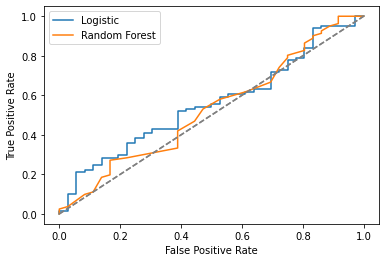

In [52]:
lr = plot_roc_curve(model_lr, X_val, y_val, label='Logistic')
rf = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_, label='Random Forest')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

In [53]:
# The end 